# Multiclass classification with MLF_GP1_CreditScore

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from keras_tuner import RandomSearch
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

#### EDA(For detailed exploratory data analysis, please refer to the MLF_GP1_EDA.ipynb)

In [2]:
MLF_GP1 = pd.read_csv("MLF_GP1_CreditScore.csv")
MLF_GP1.head()

,Sales/Revenues,Gross Margin,EBITDA,EBITDA Margin,Net Income Before Extras,Total Debt,Net Debt,LT Debt,ST Debt,Cash,...,Interest Coverage,Total Liquidity,Current Liquidity,Current Liabilities,EPS Before Extras,PE,ROA,ROE,InvGrd,Rating
0,-0.005496,0.030763,0.018885,0.024515,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,...,0.136748,0.392143,-0.184887,0.062781,0.148305,0.100409,0.163266,0.102521,1,A1
1,-0.005496,0.030763,0.088716,0.094733,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,...,0.214657,0.392143,-0.184887,0.062781,0.148305,-0.089598,0.163266,0.102521,1,A1
2,-0.007045,0.023159,0.088716,0.096440,0.108590,0.039410,0.034268,0.009059,0.250371,0.101315,...,0.205290,0.483257,-0.017877,0.121357,0.110656,-0.045142,0.105711,0.103378,1,A1
3,-0.009396,0.028400,0.088716,0.099046,0.146137,0.030071,0.036938,-0.016964,0.356994,-0.052606,...,0.232991,0.996955,-0.122017,0.079051,0.151639,-0.008231,0.162421,0.132295,1,A1
4,-0.009009,0.027714,0.088716,0.098611,0.123500,0.024224,0.034445,-0.034132,0.461894,-0.090869,...,0.172906,1.711426,-0.161561,0.084319,0.130435,0.015528,0.156427,0.225144,1,A1


In [3]:
name_list = []
counts = []
for i in MLF_GP1['Rating']:
    if i in name_list:
        counts[name_list.index(i)] += 1
    else:
        name_list.append(i)
        counts.append(1)
order = ['Aaa', 'Aa2', 'Aa3', 'A1', 'A2', 'A3', 'Baa1', 'Baa2', 'Baa3',
         'Ba1', 'Ba2', 'Ba3', 'B1', 'B2', 'B3', 'Caa1']
counts_new = []
for i in range(len(order)):
    counts_new.append(counts[name_list.index(order[i])])

In [4]:
inv = np.sum(np.array(counts_new)[:9])
junk = np.sum(np.array(counts_new)[9:])
print("There are a total of {} obseravtaions are investment grade.".format(inv))
print("There are a total of {} obseravtaions are junk grade.".format(junk))

There are a total of 1287 obseravtaions are investment grade.
There are a total of 413 obseravtaions are junk grade.


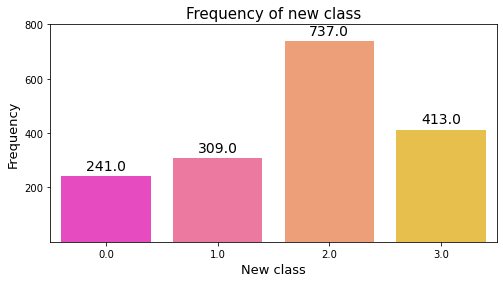

In [5]:
y_Rating = MLF_GP1['Rating'].copy()
first_class = ['Aaa', 'Aa2', 'Aa3']
second_class = ['A1', 'A2', 'A3']
third_class = ['Baa1', 'Baa2', 'Baa3']
fourth_class = ['Ba1', 'Ba2', 'Ba3', 'B1', 'B2', 'B3', 'Caa1']
multiRating = np.zeros(len(y_Rating))
for i in range(len(y_Rating)):
    if y_Rating[i] in first_class:
        multiRating[i] = 0
    elif y_Rating[i] in second_class:
        multiRating[i] = 1
    elif y_Rating[i] in third_class:
        multiRating[i] = 2
    elif y_Rating[i] in fourth_class:
        multiRating[i] = 3
        
df = MLF_GP1.copy()
df['multiRating'] = multiRating    
# bar plot of multiRating
value_counts = df['multiRating'].value_counts()
class_counts = pd.DataFrame({'Class': list(value_counts.index), 'value_count': value_counts})

plt.figure(figsize = (8,4))
g = sns.barplot(x = 'Class', y = 'value_count', data = class_counts, capsize = 0.3, palette = 'spring')
g.set_title("Frequency of new class", fontsize = 15)
g.set_xlabel("New class", fontsize = 13)
g.set_ylabel("Frequency", fontsize = 13)
g.set_yticks([200, 400, 600, 800])
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha = 'center', va = 'center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

In [6]:
# Store the features in dataframe X
X = MLF_GP1[MLF_GP1.columns.values[:-2]]

# Standardize the features
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns = X.columns.values)
X_std.shape

(1700, 26)

## Multiclass Classification

In [7]:
# split in a stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X.copy(), multiRating, test_size = 0.25, 
                                                    stratify = multiRating, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1275, 26), (425, 26), (1275,), (425,))

In [8]:
scalerX = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train), columns = X.columns.values) 
X_test = pd.DataFrame(scalerX.transform(X_test), columns = X.columns.values) 
pca = PCA(n_components = 15)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [9]:
# fit four basic classifier models
basic_classifier = ['logreg', 'Knn', 'decision tree', 'SVC']
estimator = [LogisticRegression(random_state = 123),
             KNeighborsClassifier(),
             DecisionTreeClassifier(random_state = 123),
             SVC(random_state = 123)]
for i in range(4):
    cv_score = cross_val_score(estimator[i], X_train, y_train, cv = 5)
    print('The accuracy score of 5-fold cross validation for {} is {} +/- {}'.format(basic_classifier[i],
                                                                                   np.round(np.mean(cv_score), 3),
                                                                                   np.round(np.std(cv_score), 3)))
    clf = estimator[i]
    clf.fit(X_train, y_train)
    print('The test accuracy score for {} is {}'.format(basic_classifier[i],
                                                         np.round(clf.score(X_test, y_test), 3)))
    print('----------------------------------------------------------------------')   

The accuracy score of 5-fold cross validation for logreg is 0.434 +/- 0.013
The test accuracy score for logreg is 0.454
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for Knn is 0.481 +/- 0.035
The test accuracy score for Knn is 0.499
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for decision tree is 0.46 +/- 0.016
The test accuracy score for decision tree is 0.461
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for SVC is 0.454 +/- 0.01
The test accuracy score for SVC is 0.459
----------------------------------------------------------------------


<font color=blue>Clearly, the KNN classifier has the best porformances since it has the highest cv training socre as well as the highest test score.</font>

### KNN Classifier

In [10]:
# Hyperparameters tuning 
knn = KNeighborsClassifier()
nn = np.arange(3, 15)
weights = ['uniform', 'distance']

# define grid search
grid = dict(n_neighbors = nn, weights = weights)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
grid_search = GridSearchCV(estimator = knn, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = skf, 
                           scoring = 'accuracy', 
                           error_score = 0)
knn_cv = grid_search.fit(X_train, y_train)

In [11]:
knn_index = np.argmax(knn_cv.cv_results_['mean_test_score'])
knn_mean_train = np.round(knn_cv.best_score_, 3)
knn_std_train = np.round(knn_cv.cv_results_['std_test_score'][knn_index], 3)
knn_score = str(knn_mean_train) + ' +/- ' + str(knn_std_train)
print('The accuracy score of 5-fold cross validation is ' + knn_score)

The accuracy score of 5-fold cross validation is 0.515 +/- 0.026


In [12]:
print('The best parameters using cv is {}'.format(knn_cv.best_params_))

The best parameters using cv is {'n_neighbors': 7, 'weights': 'distance'}


In [13]:
knn = knn_cv.best_estimator_

knn_test = np.round(knn.score(X_test, y_test), 3)
print('The test accuracy score is',knn_test)

The test accuracy score is 0.504


### Random Forest Classfier

In [14]:
single_tree = DecisionTreeClassifier(random_state = 123).fit(X_train, y_train)
print("The max depth for a single decision tree is", single_tree.max_features_)

The max depth for a single decision tree is 15


In [15]:
# Hyperparameters tuning for RF
rf = RandomForestClassifier(random_state = 123)
ne = [100, 300, 500]
depth = np.arange(12, 16, 1)
split = [2, 3, 4]
leaf = [1, 3, 5]
feature = ["auto", "log2", 'None']
class_weight = ['balanced', None]

# define grid search
grid = dict(n_estimators = ne, max_depth = depth, min_samples_split = split, 
            min_samples_leaf = leaf, max_features = feature, class_weight = class_weight)

grid_search = GridSearchCV(estimator = rf, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = skf, 
                           scoring = 'accuracy', 
                           error_score = 0)
rf_cv = grid_search.fit(X_train, y_train)

In [16]:
rf_index = np.argmax(rf_cv.cv_results_['mean_test_score'])
rf_mean_train = np.round(rf_cv.best_score_, 3)
rf_std_train = np.round(rf_cv.cv_results_['std_test_score'][rf_index], 3)
rf_score = str(rf_mean_train) + ' +/- ' + str(rf_std_train)
print('The accuracy score of 5-fold cross validation is ' + rf_score)

The accuracy score of 5-fold cross validation is 0.585 +/- 0.032


In [17]:
print('The best parameters using cv is {}'.format(rf_cv.best_params_))

The best parameters using cv is {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [18]:
rf = rf_cv.best_estimator_

rf_test = np.round(rf.score(X_test, y_test), 3)
print('The test accuracy score is',rf_test)

The test accuracy score is 0.668


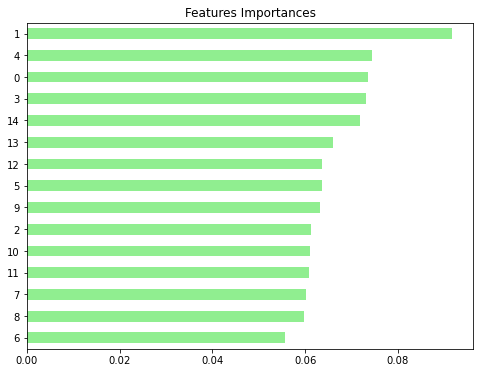

In [19]:
plt.figure(figsize = (8,6))

# Create a pd.Series of features importances
importances = pd.Series(data = rf.feature_importances_,
                        index = np.arange(0, 15, 1))

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind = 'barh', color = 'lightgreen')
plt.title('Features Importances')
plt.show()

### ANN

In [20]:
np.random.seed(123)
tf.random.set_seed(123)

In [21]:
X_train_new = X_train.astype('float32')
X_test_new = X_test.astype('float32')
y_train_new = to_categorical(y_train, 4)
y_test_new = to_categorical(y_test, 4)

In [22]:
def build_model(hp):
    model = models.Sequential()
    # Input layer
    model.add(
        layers.Dense(
            units = 15,
            activation = "relu", input_shape = (X_train_new.shape[1],)
        )
    )
    # First hidden layer
    model.add(
        layers.Dense(
            units = hp.Int("num of neurons in the hidden layer", 
                           min_value = 4, max_value = 26, step = 2, default = 26),
            activation = "relu",
        )
    )
    # Output layer
    model.add(layers.Dense(4, activation = "softmax"))
    
    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])
        ),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"],
    )
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective = "val_accuracy",
    max_trials = 5,
    seed = 123,
    overwrite = True,
    directory = "/Users/gaojinglun/Desktop/Coursework/IE517/Final Project"
)
tuner.search(X_train_new, y_train_new, epochs = 5, validation_split = 0.25)

Trial 5 Complete [00h 00m 00s]
val_accuracy: 0.39811912178993225

Best val_accuracy So Far: 0.39811912178993225
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num of neurons in the hidden layer (Int)
{'default': 26, 'conditions': [], 'min_value': 4, 'max_value': 26, 'step': 2, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
# tuner.results_summary()

In [26]:
best_paras = tuner.get_best_hyperparameters(num_trials = 1)[0]
ANN = build_model(best_paras)
ANN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 28        
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = ANN.fit(X_train_new, y_train_new, epochs = 5, validation_split = 0.25)

Epoch 1/5
30/30 [==============================] - 0s 4ms/step - loss: 1.6470 - accuracy: 0.2950 - val_loss: 1.7153 - val_accuracy: 0.3103
Epoch 2/5
30/30 [==============================] - 0s 1ms/step - loss: 1.5195 - accuracy: 0.3515 - val_loss: 1.5853 - val_accuracy: 0.3229
Epoch 3/5
30/30 [==============================] - 0s 1ms/step - loss: 1.4457 - accuracy: 0.4006 - val_loss: 1.5086 - val_accuracy: 0.3197
Epoch 4/5
30/30 [==============================] - 0s 1ms/step - loss: 1.3952 - accuracy: 0.4205 - val_loss: 1.4589 - val_accuracy: 0.3354
Epoch 5/5
30/30 [==============================] - 0s 1ms/step - loss: 1.3582 - accuracy: 0.4236 - val_loss: 1.4248 - val_accuracy: 0.3574


In [28]:
ann_mean_train = np.round(np.mean(history.history['val_accuracy']), 3)
ann_std_train = np.round(np.std(history.history['val_accuracy']), 3)
ann_score = str(ann_mean_train) + ' +/- ' + str(ann_std_train)
print('The accuracy score of 5 epochs validation is ' + ann_score)

The accuracy score of 5 epochs validation is 0.329 +/- 0.016


In [29]:
_, ann_test = ANN.evaluate(X_test_new, y_test_new)
ann_test = np.round(ann_test, 3)
print("The accuracy score for Neural Network is", ann_test)

14/14 [==============================] - 0s 614us/step - loss: 1.4397 - accuracy: 0.4306
The accuracy score for Neural Network is 0.431


## Results

<Figure size 1080x720 with 0 Axes>

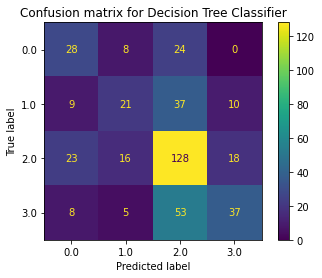

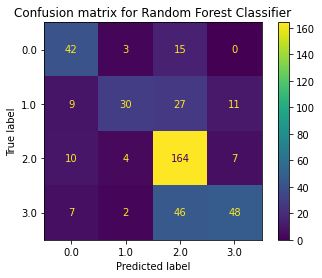

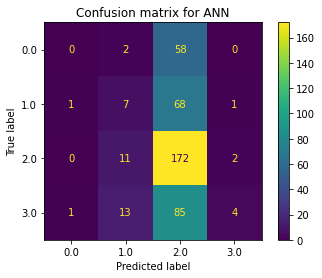

In [30]:
fig = plt.figure(figsize = (15,10))

ConfusionMatrixDisplay(confusion_matrix(y_test, knn.predict(X_test)), 
                       display_labels = knn.classes_).plot()
plt.title("Confusion matrix for Decision Tree Classifier")
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, rf.predict(X_test)), 
                       display_labels = rf.classes_).plot()
plt.title("Confusion matrix for Random Forest Classifier")
plt.show()


pred = np.argmax(ANN.predict(X_test), axis = 1)
ConfusionMatrixDisplay(confusion_matrix(y_test, pred), 
                       display_labels = rf.classes_).plot()
plt.title("Confusion matrix for ANN")
plt.show()

In [31]:
Models = ['Decision Tree', 'Random Forest', 'ANN']
train_acc = [knn_score, rf_score, ann_score]
test_acc = [knn_test, rf_test, ann_test]

table = pd.DataFrame(np.column_stack((Models, train_acc, test_acc)), 
                      columns = ['Modle Name', 'Train 5-fold CV / 5 epochs Accuracy', 'Test Accuracy'])
print(tabulate(table, headers = 'keys', showindex = False, tablefmt = "github"))

| Modle Name    | Train 5-fold CV / 5 epochs Accuracy   |   Test Accuracy |
|---------------|---------------------------------------|-----------------|
| Decision Tree | 0.515 +/- 0.026                       |           0.504 |
| Random Forest | 0.585 +/- 0.032                       |           0.668 |
| ANN           | 0.329 +/- 0.016                       |           0.431 |
